In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

This data set is chosen because it has 17 columns, which is not too much and not too low. As it is also a practical dataset, and its usage scanerio is the grouping people into different categories for the marketing process, based on the parameters such as education, housing and loan etc. I belive that I will learn in using this data. And it also has sufficient data as it has over
###### This is the link that I got the dataset https://archive.ics.uci.edu/dataset/222/bank+marketing

In [166]:
warnings.filterwarnings('ignore')

In [167]:
df=pd.read_csv("bank.csv", sep=";")
df=df.drop(columns=['y', 'default'] )
df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,1787,no,no,cellular,19,oct,79,1,-1,0,unknown
1,33,services,married,secondary,4789,yes,yes,cellular,11,may,220,1,339,4,failure
2,35,management,single,tertiary,1350,yes,no,cellular,16,apr,185,1,330,1,failure
3,30,management,married,tertiary,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,0,yes,no,unknown,5,may,226,1,-1,0,unknown


In [168]:
df.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

##### There are no missing values in this dataset.

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   balance    4521 non-null   int64 
 5   housing    4521 non-null   object
 6   loan       4521 non-null   object
 7   contact    4521 non-null   object
 8   day        4521 non-null   int64 
 9   month      4521 non-null   object
 10  duration   4521 non-null   int64 
 11  campaign   4521 non-null   int64 
 12  pdays      4521 non-null   int64 
 13  previous   4521 non-null   int64 
 14  poutcome   4521 non-null   object
dtypes: int64(7), object(8)
memory usage: 529.9+ KB


As the dataset contains objects and int values we have to convert objects into numeric values using one hot encoding, because there is no order in the data, although month can be ordered, we can also make it ordinal to make the process simpler.

Firstly, the data includes yes and no values, as it will double the number of columns if we have used one hot encoding; we map yes with 1 and no with 0. 

In [170]:
col_to_map = ['housing', 'loan']
mapping_dict = {'yes': 1, 'no': 0}
for col in col_to_map:
    df[col] = df[col].map(mapping_dict)
df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,1787,0,0,cellular,19,oct,79,1,-1,0,unknown
1,33,services,married,secondary,4789,1,1,cellular,11,may,220,1,339,4,failure
2,35,management,single,tertiary,1350,1,0,cellular,16,apr,185,1,330,1,failure
3,30,management,married,tertiary,1476,1,1,unknown,3,jun,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,0,1,0,unknown,5,may,226,1,-1,0,unknown


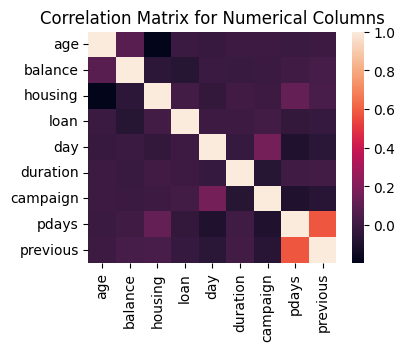

In [171]:
corr_matrix = df.select_dtypes(include='int64').corr()

plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix)
plt.title("Correlation Matrix for Numerical Columns")
plt.show()

The correlation heatmap between the numeric values give that the pdays, and previous is related, but no distinction value is found. 

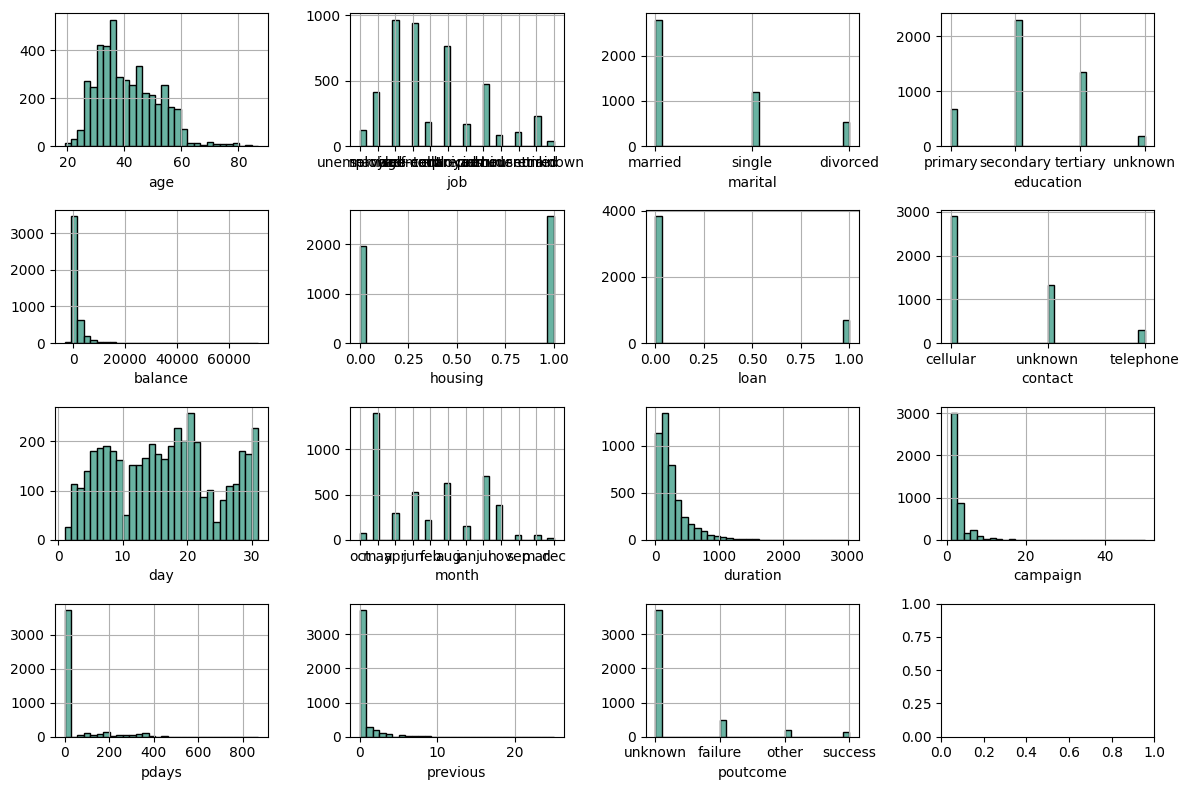

In [172]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
axes = axes.flatten()
for i,col in enumerate(df.columns):
    df[col].hist(ax=axes[i], bins=30, edgecolor='black', color='#69b3a2')

    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

The the distribution of the results shows that the data skews towards the right, and most of the values being, we will use stanard scaler for numeric variables.

We will try to create a pipeline where we will try to one hot encode the categorical columns into numeric columns, and then try to scale all of the dataset using standard scaler because, if we only scale for numeric columns, the scaled data and one hot encoded 1 and 0 will not be meaningful together. 

In [173]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), cat_cols)],
    remainder='passthrough' 
)

pre_processor = Pipeline(steps=[
    ('encoder', encoder),
    ('scaler', StandardScaler())
])

processed_array = pre_processor.fit_transform(df)

new_column_names = pre_processor.get_feature_names_out()
processed_df = pd.DataFrame(data=processed_array, index=df.index, columns=new_column_names)

##### The WCSS score for each k from 1 to 20 using all of the columns has no distinct elbow place, has elbow around 3, and 8.

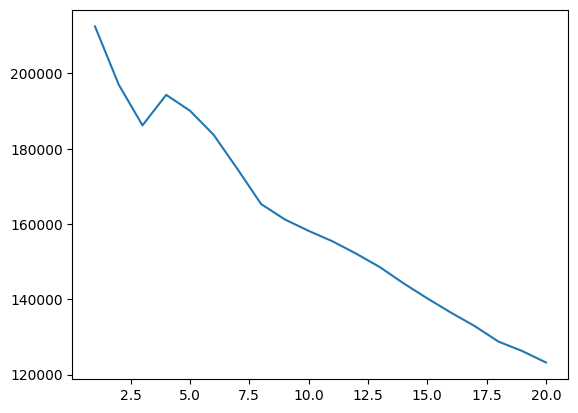

In [174]:
wcss=[]
wcss_range=range(1,21)
for k in wcss_range:
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(processed_df)
    wcss.append(kmeans.inertia_)

sns.lineplot(x=wcss_range,y=wcss,palette='husl')
plt.show()

In [175]:
silhouette_scores = []
silhouette_range = range(2, 21)

for k in silhouette_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(processed_df)

    score = silhouette_score(processed_df, labels)
    silhouette_scores.append(score)
    print(f"k={k} | Silhouette Score: {score:.4f}")

k=2 | Silhouette Score: 0.1804
k=3 | Silhouette Score: 0.0616
k=4 | Silhouette Score: 0.0546
k=5 | Silhouette Score: 0.0575
k=6 | Silhouette Score: 0.0859
k=7 | Silhouette Score: 0.0851
k=8 | Silhouette Score: 0.0918
k=9 | Silhouette Score: 0.0963
k=10 | Silhouette Score: 0.0903
k=11 | Silhouette Score: 0.0753
k=12 | Silhouette Score: 0.0809
k=13 | Silhouette Score: 0.0904
k=14 | Silhouette Score: 0.0964
k=15 | Silhouette Score: 0.1010
k=16 | Silhouette Score: 0.1081
k=17 | Silhouette Score: 0.1136
k=18 | Silhouette Score: 0.1176
k=19 | Silhouette Score: 0.1185
k=20 | Silhouette Score: 0.1187


##### The silhouette score gradually drops from 0.18 to 0.06 in k = 3 increases  from 0.06 to 0.12 in k =20 therefore, it indicates that we still need to fix the data to get a higher score. 

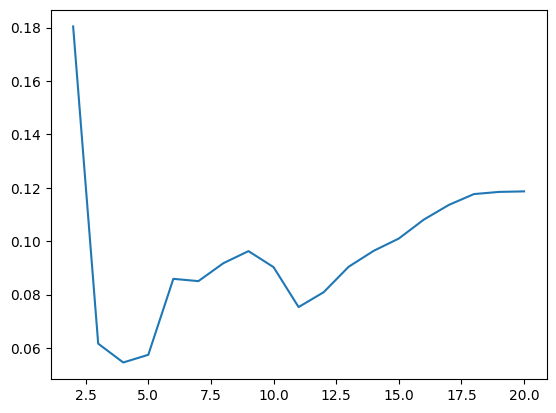

In [176]:
sns.lineplot(x=silhouette_range,y=silhouette_scores,palette='husl')
plt.show()

##### To test a new result, we will use pca and compare the two results for WCSS and Silhouette scores. 

In [177]:
encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), cat_cols)],
    remainder='passthrough' 
)

pre_processor = Pipeline(steps=[
    ('encoder', encoder),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

processed_array = pre_processor.fit_transform(df)

new_column_names = pre_processor.get_feature_names_out()
processed_df = pd.DataFrame(data=processed_array, index=df.index, columns=new_column_names)

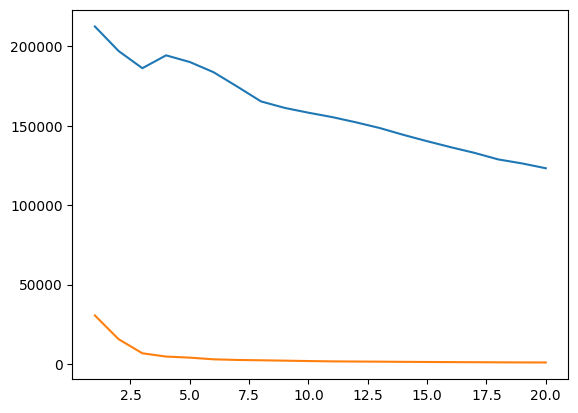

In [178]:
wcss_pca=[]
for k in wcss_range:
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(processed_df)
    wcss_pca.append(kmeans.inertia_)

sns.lineplot(x=wcss_range,y=wcss, palette='husl')
sns.lineplot(x=wcss_range, y=wcss_pca, palette='hus2')
plt.show()

For the wcss it recued from the initial value of 200,000 to 120,000,  towards range from 30,000  to approaching zero, meaning that the datapoints inside the each of the cluster are closer to thier respective cluster centres, for the same k value. 

And distinct elbow is found and k = 3. 

In [179]:
silhouette_pca = []

for k in silhouette_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(processed_df)

    score = silhouette_score(processed_df, labels)
    silhouette_pca.append(score)
    print(f"k={k} | Silhouette Score: {score:.4f}")

k=2 | Silhouette Score: 0.5712
k=3 | Silhouette Score: 0.5451
k=4 | Silhouette Score: 0.4998
k=5 | Silhouette Score: 0.4638
k=6 | Silhouette Score: 0.4405
k=7 | Silhouette Score: 0.4538
k=8 | Silhouette Score: 0.4444
k=9 | Silhouette Score: 0.4130
k=10 | Silhouette Score: 0.4155
k=11 | Silhouette Score: 0.4096
k=12 | Silhouette Score: 0.3922
k=13 | Silhouette Score: 0.3920
k=14 | Silhouette Score: 0.3920
k=15 | Silhouette Score: 0.3865
k=16 | Silhouette Score: 0.3882
k=17 | Silhouette Score: 0.3740
k=18 | Silhouette Score: 0.3733
k=19 | Silhouette Score: 0.3756
k=20 | Silhouette Score: 0.3639


##### As the points are less steep around k = 9, and it is also the shilloutte value of around 0.3 for the point around k = 9 is chose to build the model. 

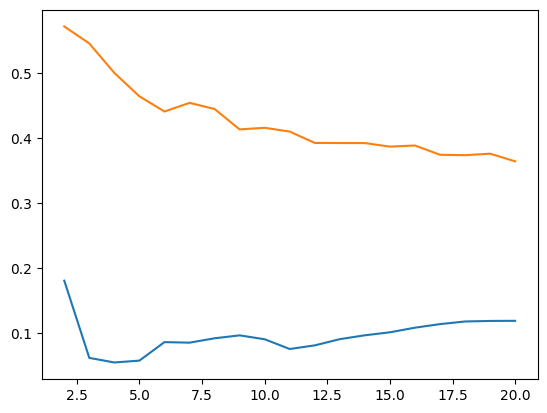

In [180]:
sns.lineplot(x=silhouette_range,y=silhouette_scores,palette='husl')
sns.lineplot(x=silhouette_range,y=silhouette_pca,palette='hus2')
plt.show()

The new slihouette score drops from 0.57 to 0.04 from k 2 to 6. But increase a bit back for k  7 and 8 but gradually decreases slightly  below 0.4 for k 20. 

This indicates that the shihouette sagnificantly increases if we use pca, there fore we will try to use it.

For deciding the best cases are k 2, with highest schillouette score, but high WCSS, k 3 is the best because it shilouette score is the highest apart from k 2. Another contenders are k 8 and k 9 becaus they have sagnificantly low WCSS, and the we can also take k 5, and 6 because they have the shilouette score increasing back. 

In terms of the results k 3 is the best safe choice because it has second highest shillouette score, and a sagnificant elbow is form near it. We will choose k 3, and create a model using it.

In [184]:
encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)],
    remainder='passthrough'
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', encoder),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(n_clusters=3, random_state=42, n_init='auto'))
])

model = model_pipeline.fit(df)
model

,steps,"[('preprocessor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


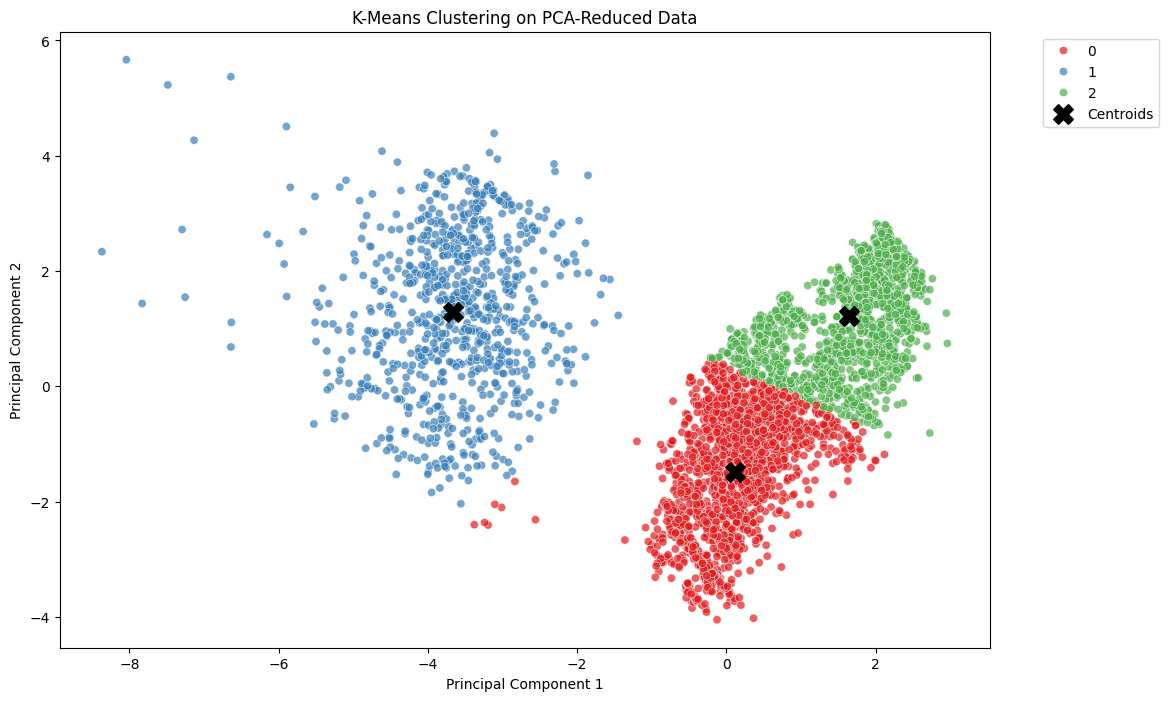

In [185]:
pca_transformed_data = model_pipeline[:-1].transform(df)

cluster_labels = model_pipeline.named_steps['kmeans'].labels_

plot_df = pd.DataFrame(pca_transformed_data, columns=['PC1', 'PC2'])
plot_df['cluster'] = cluster_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_df, 
    x='PC1', 
    y='PC2', 
    hue='cluster', 
    palette='Set1', 
    legend='full', 
    alpha=0.7
)

centers = model_pipeline.named_steps['kmeans'].cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='X', label='Centroids')

plt.title('K-Means Clustering on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [186]:
with open('bank_kmeans.pkl', 'wb') as f:
    joblib.dump(model, f)